#### maps with north arrow and scale bar

#### 0-central color bar

####  place a colorbar inside the main figure frame

Generating synthetic data...
Creating synthetic circular boundary...
Clipping data array to boundary...
Plotting clipped data...
Adding contour lines...


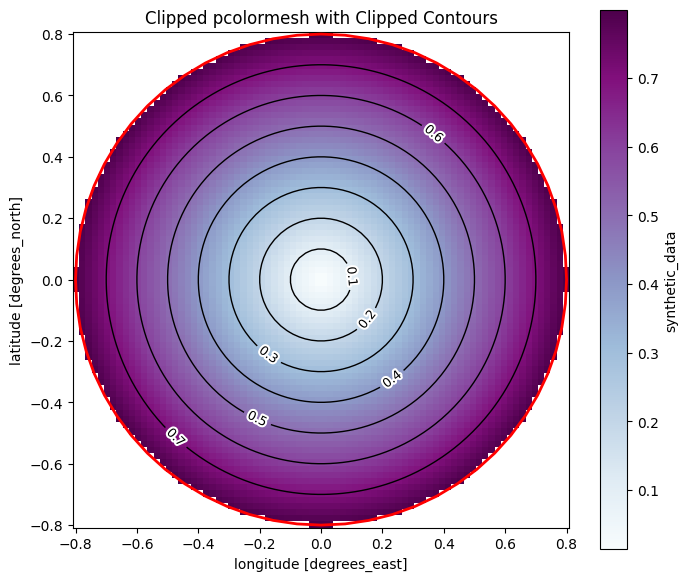

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import rioxarray # Required for the .rio accessor
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.patheffects as pe

# ==============================================================================
# 1. USER CONFIGURATION
# ==============================================================================
PLOT_CONTOURS = True       # <-- Your switch! Set to False to hide contours.
CONTOUR_LINE_COLOR = 'black'
CONTOUR_LEVELS_AUTO = 10     # Number of contours to generate automatically

# ==============================================================================
# 2. GENERATE SYNTHETIC DATA (as xarray.DataArray)
# ==============================================================================
print("Generating synthetic data...")
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
xx, yy = np.meshgrid(x, y)
data_values = np.sqrt(xx**2 + yy**2)

# Create an xarray.DataArray
# This is the same format as your 'reprojected_ds'
data_array = xr.DataArray(
    data_values,
    coords={'y': y, 'x': x},
    dims=('y', 'x'),
    name='synthetic_data'
)

# IMPORTANT: We must assign a CRS for clipping to work.
# We'll use a simple one. Your real data already has this.
data_array = data_array.rio.write_crs("EPSG:4326")
# Add coordinate system info for xarray plotting
data_array = data_array.rio.set_spatial_dims('x', 'y')

# ==============================================================================
# 3. CREATE SYNTHETIC BOUNDARY (as geopandas.GeoDataFrame)
# ==============================================================================
print("Creating synthetic circular boundary...")
# Create a circular "study area" that is smaller than the data
center_point = Point(0, 0)
circle_buffer = center_point.buffer(0.8) # Radius of 0.8

# Create a GeoDataFrame
# This is the same format as your 'boundary_gdf_wgs84'
boundary_gdf = gpd.GeoDataFrame(
    {'geometry': [circle_buffer], 'id': [1]},
    crs="EPSG:4326"
)

# ==============================================================================
# 4. CLIP DATA TO BOUNDARY
# ==============================================================================
print("Clipping data array to boundary...")
# This is the most important step.
# It uses the boundary_gdf to "cut" the data_array.
# All pixels outside the circle will become np.nan
try:
    clipped_data_array = data_array.rio.clip(boundary_gdf.geometry)
except Exception as e:
    print(f"Clipping error: {e}")
    print("Falling back to unclipped data for demo.")
    clipped_data_array = data_array

# ==============================================================================
# 5. PLOT THE DATA
# ==============================================================================
print("Plotting clipped data...")
fig, ax = plt.subplots(figsize=(8, 7))

# --- Plot the pcolormesh ---
# When plotting the 'clipped_data_array', pcolormesh
# will automatically ignore the 'nan' values outside the circle.
clipped_data_array.plot.pcolormesh(
    ax=ax,
    cmap='BuPu', # Using your program's colormap
    add_colorbar=True,
    zorder=1
)

# --- Plot the Contour Lines (using the switch) ---
if PLOT_CONTOURS:
    print("Adding contour lines...")
    # We plot contours from the *exact same* clipped data.
    # The contour lines will also stop at the 'nan' boundary.
    CS = clipped_data_array.plot.contour(
        ax=ax,
        levels=CONTOUR_LEVELS_AUTO,
        colors=CONTOUR_LINE_COLOR,
        linewidths=1.0,
        zorder=2 # Place contours on top of the pcolormesh
    )
    
    # --- Add Halo Labels to Contours ---
    # We can use the same halo technique as before
    clabel_texts = ax.clabel(
        CS,
        inline=True,
        fontsize=9,
        colors=CONTOUR_LINE_COLOR,
        fmt='%1.1f'
    )
    
    # Apply the white halo
    plt.setp(
        clabel_texts,
        path_effects=[
            pe.withStroke(linewidth=3, foreground='white')
        ]
    )

# --- Plot the boundary on top for reference ---
boundary_gdf.plot(
    ax=ax,
    facecolor='none',
    edgecolor='red',
    linewidth=2,
    zorder=3
)

ax.set_title("Clipped pcolormesh with Clipped Contours")
ax.set_aspect('equal')
plt.show()